In [91]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np

sys.path.append("/eos/home-g/gkrzmanc/mlpf_data")
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
#import dgl  # CPU only version for now
from tqdm import tqdm
from torch_scatter import scatter_sum, scatter_mean
import matplotlib.pyplot as plt
import pickle
import numpy as np
import mplhep as hep

hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)



In [2]:
# This block is the same as 1_dataset.ipynb

#datasets = os.listdir("/eos/user/m/mgarciam/datasets_mlpf/230923_20_25")
#dataset = "/eos/user/g/gkrzmanc/ClicDet_v1_25_07_2023_full.root"

def remove_from_list(lst):
    out = []
    for item in lst:
        if item in ["hgcal", "data.txt", "test_file.root"]:
            continue
        out.append(item)
    return out

#datasets = [os.path.join("/eos/user/m/mgarciam/datasets_mlpf/230923_20_25", x) for x in remove_from_list(datasets)]
datasets = ["/eos/experiment/fcc/ee/datasets/mlpf/CLD/eval/300424/Ks_v1/pf_tree_1.root",
            "/eos/experiment/fcc/ee/datasets/mlpf/CLD/eval/300424/Ks_v1/pf_tree_2.root",
            "/eos/experiment/fcc/ee/datasets/mlpf/CLD/eval/300424/Ks_v1/pf_tree_3.root",
            "/eos/experiment/fcc/ee/datasets/mlpf/CLD/eval/300424/Ks_v1/pf_tree_4.root",]
class Args:
    def __init__(self):
        self.data_train = datasets
        self.data_val = datasets
        #self.data_train = files_train
        self.data_config = '/afs/cern.ch/work/g/gkrzmanc/mlpf_2024/config_files/config_hits_track_ks_v1.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 10
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False


args = Args()
train_range = (0, args.train_val_split)
train_file_dict, train_files = to_filelist(args, 'train')
train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                               extra_selection=args.extra_selection,
                               remake_weights=True,
                               load_range_and_fraction=(train_range, args.data_fraction),
                               file_fraction=args.file_fraction,
                               fetch_by_files=args.fetch_by_files,
                               fetch_step=args.fetch_step,
                               infinity_mode=False,
                               in_memory=args.in_memory,
                               async_load=False,
                               name='train')

['/eos/experiment/fcc/ee/datasets/mlpf/CLD/eval/300424/Ks_v1/pf_tree_1.root', '/eos/experiment/fcc/ee/datasets/mlpf/CLD/eval/300424/Ks_v1/pf_tree_2.root', '/eos/experiment/fcc/ee/datasets/mlpf/CLD/eval/300424/Ks_v1/pf_tree_3.root', '/eos/experiment/fcc/ee/datasets/mlpf/CLD/eval/300424/Ks_v1/pf_tree_4.root']


In [20]:
iterator = iter(train_data)
g, gt = next(iterator)
g.ndata['particle_number'].unique()
from src.dataset.functions_graph import graph_batch_func

train_loader = DataLoader(train_data, batch_size=1, drop_last=True, pin_memory=True,
                          num_workers=min(args.num_workers, int(len(train_files) * args.file_fraction)),
                          collate_fn=graph_batch_func,
                          persistent_workers=args.num_workers > 0 and args.steps_per_epoch is not None)
iterator = iter(train_loader)


=== Restarting DataIter train, seed=None ===
Using config with part_pxyz and part_vertex_xyz
=== Restarting DataIter train, seed=None ===


In [4]:
g, y = next(iterator)

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


In [17]:
g.ndata["pandora_reference_point"]

tensor([[-1.0000e+00, -1.0000e+00, -1.0000e+00],
        [-1.0000e+00, -1.0000e+00, -1.0000e+00],
        [-1.7512e+03, -1.3619e+03, -1.2109e+02],
        [-1.7512e+03, -1.3619e+03, -1.2109e+02],
        [-1.7512e+03, -1.3619e+03, -1.2109e+02],
        [-1.7512e+03, -1.3619e+03, -1.2109e+02],
        [-1.7512e+03, -1.3619e+03, -1.2109e+02],
        [-1.7512e+03, -1.3619e+03, -1.2109e+02],
        [-1.7512e+03, -1.3619e+03, -1.2109e+02],
        [-1.7512e+03, -1.3619e+03, -1.2109e+02],
        [-1.7512e+03, -1.3619e+03, -1.2109e+02],
        [-1.7512e+03, -1.3619e+03, -1.2109e+02],
        [-1.7512e+03, -1.3619e+03, -1.2109e+02],
        [-1.7512e+03, -1.3619e+03, -1.2109e+02],
        [-1.7512e+03, -1.3619e+03, -1.2109e+02],
        [-1.7512e+03, -1.3619e+03, -1.2109e+02],
        [-1.0000e+00, -1.0000e+00, -1.0000e+00],
        [-1.7512e+03, -1.3619e+03, -1.2109e+02],
        [-1.7512e+03, -1.3619e+03, -1.2109e+02],
        [-3.1492e+01, -2.7350e+03,  3.9844e+02],
        [-3.1492e+01

In [93]:
tracks = g.ndata["h"][:, 7] != 0
tracks_vectors = g.ndata["pos_pxpypz"][tracks]
# normalize
particles = g.ndata["particle_number"].long()
tracks_vectors = tracks_vectors / torch.norm(tracks_vectors, dim=1)[:, None]
tracks_part_num = particles[tracks]

avg_particles_tracks = scatter_sum(tracks_vectors, tracks_part_num, dim=0)
avg_hits_pos_particle = scatter_sum(g.ndata["pos_hits_xyz"], particles, dim=0, dim_size=particles.max() + 1)
if tracks.sum() > 0:
    avg_hits_pos_track = scatter_sum(g.ndata["pos_hits_xyz"][tracks], tracks_part_num, dim=0, dim_size=particles.max() + 1)
else:
    avg_hits_pos_track = []
hits_vectors = avg_hits_pos_track[1:] - y.vertex
hits_vectors = hits_vectors / torch.norm(hits_vectors, dim=1)[:, None]
true_vectors = y.coord

In [94]:
tracks_part_num

tensor([1, 2])

In [95]:
tracks_vectors

tensor([[-0.7831,  0.3050, -0.5421],
        [-0.5807, -0.7483,  0.3208]])

In [56]:
distances_tracks = (true_vectors - tracks_vectors).norm(dim=1)
distances_hits = (true_vectors - avg_particles_tracks[1:]).norm(dim=1)

tensor([[-0.2587, -0.9518,  0.1649],
        [-0.2699, -0.9613, -0.0548]])

In [96]:
num_particles = []
ys = []

num_tracks = []
hits_dist, tracks_dist = [], []

# num particles
for g, y  in tqdm(train_loader):
    pids = y.pid.shape[0]
    num_particles.append(pids)
    ys.append(y)
    tracks = g.ndata["h"][:, 7] != 0
    tracks_vectors = g.ndata["pos_pxpypz"][tracks]
    # normalize
    particles = g.ndata["particle_number"].long()
    tracks_vectors = tracks_vectors / torch.norm(tracks_vectors, dim=1)[:, None]
    tracks_part_num = particles[tracks]
    avg_particles_tracks = scatter_sum(tracks_vectors, tracks_part_num, dim=0, dim_size=particles.max() + 1)
    avg_hits_pos_particle = scatter_sum(g.ndata["pos_hits_xyz"], particles, dim=0, dim_size=particles.max() + 1)
    true_vectors = y.coord
    if tracks.sum() > 0:
        avg_hits_pos_track = scatter_mean(tracks_vectors, tracks_part_num, dim=0, dim_size=particles.max() + 1)
        print(true_vectors.shape)
        print(avg_hits_pos_track[1:].shape)
        distances_tracks = (true_vectors - avg_hits_pos_track[1:]).norm(dim=1)
    else:
        avg_hits_pos_track = []
        distances_tracks = None
    hits_vectors = avg_hits_pos_particle[1:] - y.vertex
    hits_vectors = hits_vectors / torch.norm(hits_vectors, dim=1)[:, None]
    
    #print("TV", true_vectors)
    #print("a", avg_particles_tracks[1:])
    distances_hits = (true_vectors - hits_vectors).norm(dim=1)
    hits_dist.append(distances_hits)
    tracks_dist.append(distances_tracks)
    num_tracks.append(tracks_vectors.shape[0])


0it [00:00, ?it/s]

=== Restarting DataIter train, seed=None ===


1it [00:01,  1.22s/it]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


4it [00:01,  2.48it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


8it [00:02,  4.08it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz


11it [00:02,  4.50it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz


15it [00:03,  4.30it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])


19it [00:04,  4.93it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([3, 3])
torch.Size([3, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz


22it [00:05,  5.03it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz


26it [00:05,  5.63it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


29it [00:06,  5.51it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


33it [00:06,  5.92it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


37it [00:07,  5.18it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


41it [00:08,  5.61it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([3, 3])
torch.Size([3, 3])
Using config with part_pxyz and part_vertex_xyz


45it [00:09,  5.96it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz


51it [00:09,  6.63it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


54it [00:10,  5.39it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz


58it [00:11,  5.60it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([3, 3])
torch.Size([3, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


62it [00:12,  4.79it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([4, 3])
torch.Size([4, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([3, 3])
torch.Size([3, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz


65it [00:12,  4.78it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


69it [00:13,  5.35it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz


73it [00:14,  5.80it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz


78it [00:14,  6.03it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz


81it [00:15,  5.45it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz


85it [00:16,  4.91it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz


91it [00:17,  6.05it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])


93it [00:17,  4.89it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


97it [00:18,  5.28it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


101it [00:19,  5.78it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


105it [00:19,  5.57it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


109it [00:21,  4.83it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


113it [00:21,  5.23it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([4, 3])
torch.Size([4, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([6, 3])
torch.Size([6, 3])
Using config with part_pxyz and part_vertex_xyz


117it [00:22,  5.67it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz


119it [00:22,  6.14it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


121it [00:23,  5.08it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


125it [00:23,  5.06it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz


128it [00:24,  4.93it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


132it [00:25,  4.57it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz


136it [00:26,  5.12it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


137it [00:26,  5.05it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([3, 3])
torch.Size([3, 3])


139it [00:27,  4.29it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


143it [00:27,  5.15it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([4, 3])
torch.Size([4, 3])


147it [00:28,  5.75it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


151it [00:28,  6.14it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


156it [00:29,  5.45it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


158it [00:30,  4.52it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([3, 3])
torch.Size([3, 3])


162it [00:31,  5.22it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([3, 3])
torch.Size([3, 3])
Using config with part_pxyz and part_vertex_xyz


166it [00:31,  5.63it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


170it [00:32,  5.98it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


174it [00:32,  6.17it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])


178it [00:33,  5.35it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


182it [00:34,  5.64it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([8, 3])
torch.Size([8, 3])


186it [00:35,  5.85it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


191it [00:35,  6.06it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


194it [00:36,  5.50it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([3, 3])
torch.Size([3, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


198it [00:37,  5.95it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([3, 3])
torch.Size([3, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


202it [00:38,  5.23it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


209it [00:38,  6.76it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


212it [00:39,  5.63it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


214it [00:40,  3.77it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz


218it [00:41,  4.90it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


222it [00:41,  5.49it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([3, 3])
torch.Size([3, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


226it [00:42,  4.89it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


228it [00:42,  5.43it/s]

Using config with part_pxyz and part_vertex_xyz


230it [00:43,  4.53it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([4, 3])
torch.Size([4, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([4, 3])
torch.Size([4, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz


234it [00:44,  5.24it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


238it [00:44,  5.72it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


241it [00:45,  5.59it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([5, 3])
torch.Size([5, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


245it [00:46,  4.86it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


249it [00:47,  4.31it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


254it [00:47,  5.24it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


259it [00:48,  5.48it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


261it [00:49,  4.26it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


262it [00:50,  4.39it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


265it [00:50,  3.98it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


268it [00:51,  4.06it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


271it [00:52,  3.60it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([13, 3])
torch.Size([13, 3])
Using config with part_pxyz and part_vertex_xyz


275it [00:53,  3.77it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz


278it [00:54,  4.17it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


282it [00:54,  4.98it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


286it [00:55,  5.58it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([5, 3])
torch.Size([5, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


290it [00:55,  5.98it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


293it [00:56,  4.78it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([1, 3])
torch.Size([1, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


297it [00:57,  5.26it/s]

Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])


302it [00:58,  5.66it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz


308it [00:58,  5.30it/s]

Using config with part_pxyz and part_vertex_xyz
torch.Size([2, 3])
torch.Size([2, 3])
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz
Using config with part_pxyz and part_vertex_xyz


In [5]:
res = {}   # number of particles to PIDs

for i in range(len(num_particles)):
    if num_particles[i] not in res:
        res[num_particles[i]] = []
    res[num_particles[i]].append(ys[i].pid.tolist())

In [6]:
import pandas as pd
pd.Series(num_particles).value_counts(normalize=True)

2    0.421053
4    0.276316
1    0.131579
3    0.078947
5    0.052632
6    0.039474
dtype: float64

In [7]:
res.keys()

dict_keys([2, 4, 1, 3, 5, 6])

In [9]:
res[2]

[[[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[22.0], [22.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]],
 [[-211.0], [211.0]]]

In [10]:
res[4]

[[[22.0], [22.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [22.0]],
 [[-211.0], [211.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [-11.0]],
 [[22.0], [22.0], [22.0], [-11.0]],
 [[22.0], [22.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [22.0]],
 [[22.0], [22.0], [22.0], [22.0]]]

In [11]:
res[5]

[[[22.0], [22.0], [22.0], [22.0], [22.0]],
 [[22.0], [11.0], [22.0], [22.0], [22.0]],
 [[22.0], [11.0], [-11.0], [22.0], [22.0]],
 [[22.0], [11.0], [-11.0], [22.0], [22.0]]]

In [78]:
tracks_dist

[tensor([0.4064, 1.2241]),
 None,
 tensor([1.5080, 0.3694]),
 None,
 tensor([1.5080, 0.3694]),
 tensor([0.4064, 1.2241]),
 None,
 None,
 tensor([0.2023, 0.0836]),
 tensor([0.8188, 0.6585]),
 None,
 tensor([1.9507, 1.1407]),
 None,
 tensor([0.7283, 1.7546]),
 tensor([0.7414]),
 None,
 tensor([0.9683, 1.9345]),
 tensor([0.6409]),
 tensor([0.3855, 0.8840, 0.3766]),
 None,
 tensor([0.5478, 0.3933]),
 None,
 None,
 tensor([1.2868]),
 tensor([0.6043, 0.3219]),
 None,
 tensor([1.0065]),
 None,
 tensor([1.4285]),
 None,
 tensor([0.4532, 0.6843]),
 None,
 tensor([0.1623, 0.3879]),
 tensor([1.0000, 0.5850]),
 tensor([1.2854]),
 None,
 None,
 None,
 None,
 None,
 None,
 None]

42

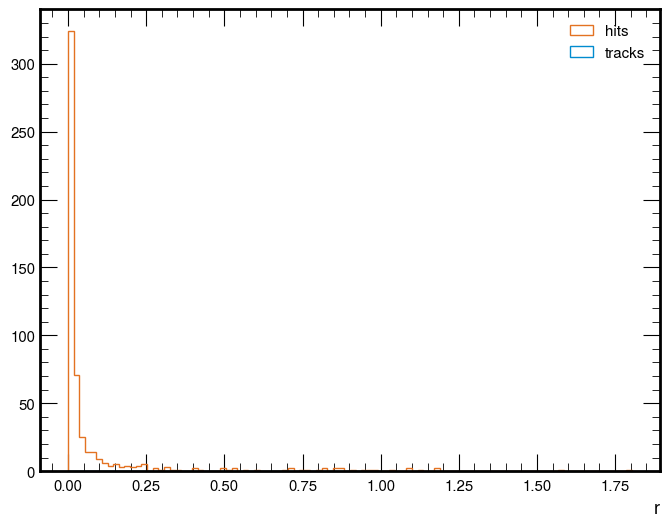

In [109]:
nt = 0 # looking at events with 2 tracks
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
_dists = []
_dists_tracks = []
for i in range(len(hits_dist)):
    if num_tracks[i] == nt:
        dists = hits_dist[i].tolist()
        if tracks_dist[i] is not None:
            dists_tracks = tracks_dist[i].tolist()
            _dists_tracks += dists_tracks
        _dists += dists
# CMS color scheme
colors = ["#E37222", "#018BCF", "#58595B", "#FFDF35", "#4D4D4F", "#B0B1B2", "#646567", "#8F918B", "#CF8E21", "#A7A8AA"]
ax.hist(_dists, bins=100, histtype="step", label="hits", color=colors[0])
ax.hist(_dists_tracks, bins=100, histtype="step", label="tracks", color=colors[1])
ax.set_xlabel("r")
ax.legend()
fig.show()

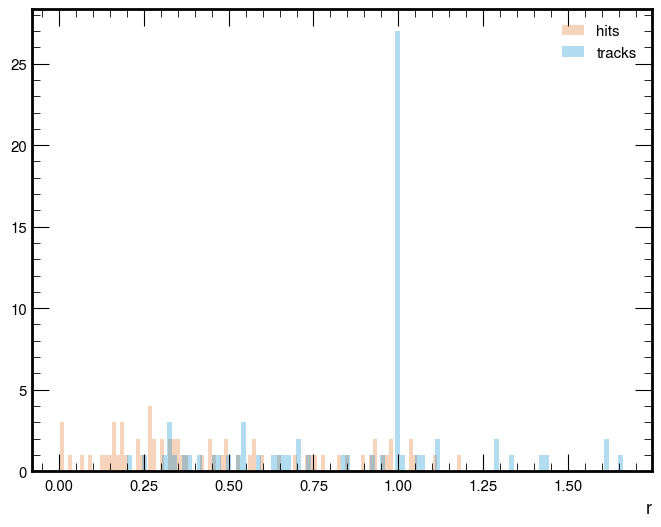

In [108]:
nt = 1 # looking at events with 2 tracks
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
_dists = []
_dists_tracks = []
for i in range(len(hits_dist)):
    if num_tracks[i] == nt:
        dists = hits_dist[i].tolist()
        if tracks_dist[i] is not None:
            dists_tracks = tracks_dist[i].tolist()
            _dists_tracks += dists_tracks
        _dists += dists
# CMS color scheme
colors = ["#E37222", "#018BCF", "#58595B", "#FFDF35", "#4D4D4F", "#B0B1B2", "#646567", "#8F918B", "#CF8E21", "#A7A8AA"]
ax.hist(_dists, bins=100, alpha=0.3, label="hits", color=colors[0])
ax.hist(_dists_tracks, bins=100, alpha=0.3, label="tracks", color=colors[1])
ax.set_xlabel("r")
ax.legend()
fig.show()

69

69